# Signal and Background - Composite Models

Data science is a broad field where similar techniques can be applied to a small set of fundamental questions. One of these key questions is that of classification; Is an instance of your data set, one event, a signal or a background? In high energy physics, as in most fields, isolating just the desired measurements is a non trivial matter and in many cases is impossible. Instead we must construct a composite model, one that combines signal and one or more types of background.  

A composite model *M(x)* is constructed from a model *S(x)* describing signal and *B(x)* describing background as 
$$M(x) = fS(x)+(1-f)B(x)$$
Where f is the fraction of events in the sample that are signal-like. The generic expression for a sum of N hypotheses is;
$$M(x)=\sum_{i=1}^{N-1}f_1F_1(x)+\left(1-\sum_{i=1}^{N-1}f_i\right)F_N(x)$$
Adding p.d.f's in this was means that *M(x)* does not need to be explicitly normalized to one since if S(x) and B(x) are normalized to one then M(x) is by construction also normalised to one. 

## Extended Likelihood Formalism

Often we would rather express a mesurement as a number of events rather than a fraction. i.e.
$$M_E(x)=N_sS(x)+N_BB(X)$$
Where $M_E(X)$ is normalised to $N_S+N_B = N$ instead of one. This means that $M_E(x)$ is not a true p.d.f. but rather an expression for two quantities, the shape and the number of events in the distributions.
$$M(x)=\left(\frac{N_S}{N_S+N_N}\right)S(x)+\left(\frac{N_B}{N_S+N_B}\right)B(X)$$
$$N_{expected}=N_S+N_B$$
Can be jointly constrained in the extended likelihood formalism:
$$-\log L(p)=-\sum_{data}\log M(x_i)-\log Poisson(N_{expected},N_{observerd})$$
In roofit the regular sums are represented by the RooAddPdf class that will automatically construct the extended likelihood term in the latter case. 

## Building Composite Models with Fractions

The first example is a plain composite model. I.e. using real p.d.f's not extended.

In [1]:
import ROOT
import rootnotes
c1=rootnotes.default_canvas()

Welcome to ROOTaaS 6.06/00


In [2]:
x = ROOT.RooRealVar("x","x",-10,10)

mean = ROOT.RooRealVar("mean","mean",0,-10,10)
sigma = ROOT.RooRealVar("sigma","sigma",2,0.,10)
sig = ROOT.RooGaussian("sig","signal p.d.f.",x,mean,sigma)

coef0 = ROOT.RooRealVar("c0","coefficient #0",1.0,-1.,1)
coef1 = ROOT.RooRealVar("c1","coefficient #1",0.1,-1.,1)
coef2 = ROOT.RooRealVar("c2","coefficient #2",-0.1,-1.,1)
bkg = ROOT.RooChebychev("bkg","background p.d.f.",x,ROOT.RooArgList(coef0,coef1,coef2))

fsig = ROOT.RooRealVar("fsig","signal fraction",0.5,0.,1.)

# model(x) = fsig*sig(x) + (1-fsig)*bkg(x)
model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(sig,bkg),ROOT.RooArgList(fsig))


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Here we define two p.d.f's and then create a model which is the sum of the two. 

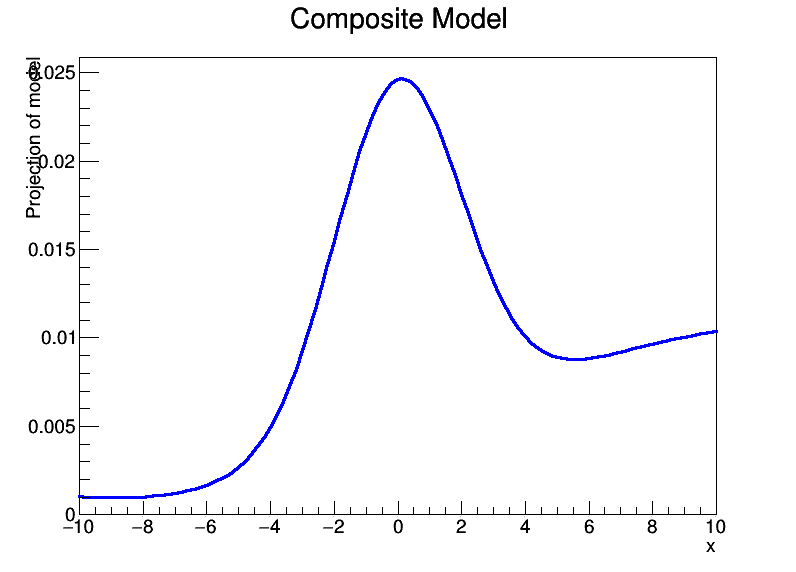

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpZwN5Jn.png has been created


In [3]:
xframe = x.frame(ROOT.RooFit.Title("Composite Model"))
model.plotOn(xframe)
xframe.Draw()
c1

Here we have specified that the models are combined with a fraction of the two = 0.5 but what happens if we change this fraction (*fsig*) ?

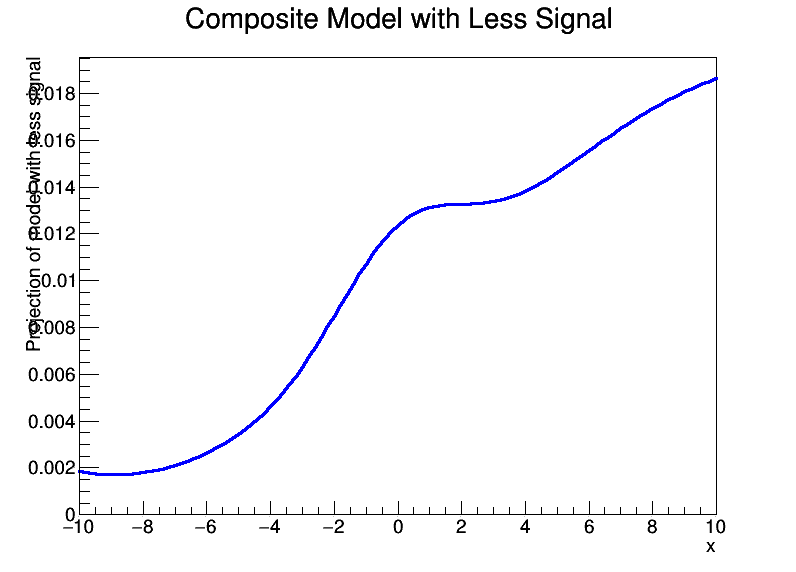

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmphNT7Ks.png has been created


In [4]:
fsig2 = ROOT.RooRealVar("fsig2","new signal fraction",0.1,0.,1.)
model2 = ROOT.RooAddPdf("model2","model with less signal",ROOT.RooArgList(sig,bkg),ROOT.RooArgList(fsig2))
xframe = x.frame(ROOT.RooFit.Title("Composite Model with Less Signal"))
model2.plotOn(xframe)
xframe.Draw()
c1

A RooAddPdf instance can also be used to add together more components, for example we can add a third pdf, called bkg_peak, or even add them recursively

In [ ]:
# model2(x) = fsig*sig(x) + fbkg1*bkg1(x) + (1-fsig-fbkg)*bkg2(x)
model2 = ROOT.RooAddPdf("model2","model2",ROOT.RooArgList(sig,bkg1,bkg2),ROOT.RooArgList(fsig,fbkg1))

However then we must be careful which fraction compares to what

In [5]:
# this is for the third peak
mean_bkg = ROOT.RooRealVar("mean_bkg","mean",0,-10,10)
sigma_bkg = ROOT.RooRealVar("sigma_bkg","sigma",2,0.,10.)
bkg_peak = ROOT.RooGaussian("bkg_peak","peaking bkg p.d.f",x,mean_bkg,sigma_bkg)

# first add the sig and the peak together with fraction fpeak
fpeak = ROOT.RooRealVar("fpeak","peaking background fraction",0.1,0.,1.)
sigpeak = ROOT.RooAddPdf("sigpeak","sig+peaking background",ROOT.RooArgList(bkg_peak,sig),ROOT.RooArgList(fpeak))

# now we can add (sig+peak) to bkg with the fraction fpeak
fbkg = ROOT.RooRealVar("fbkg","background fraction",0.5,0.,1.)
model2 = ROOT.RooAddPdf("model2","bkg+(sig+peak)",ROOT.RooArgList(bkg,sigpeak),ROOT.RooArgList(fbkg))

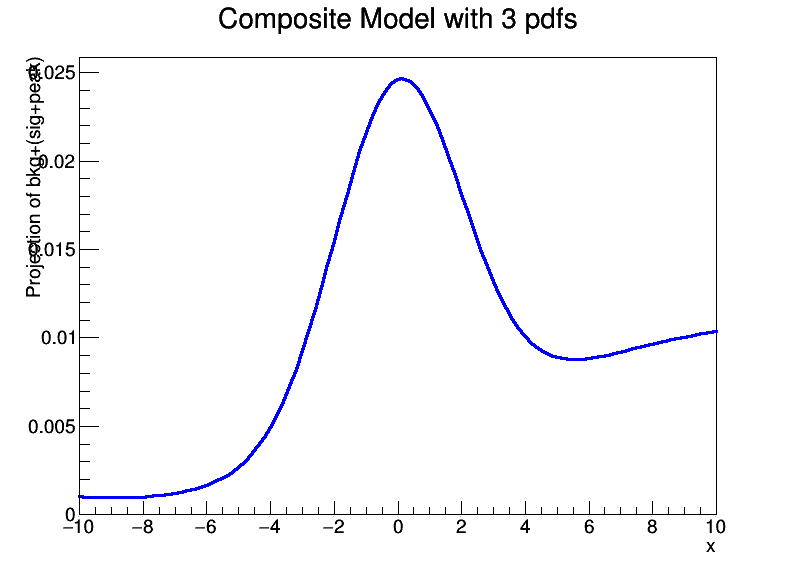

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpaiZeKg.png has been created


In [6]:
xframe = x.frame(ROOT.RooFit.Title("Composite Model with 3 pdfs"))
model2.plotOn(xframe)
xframe.Draw()
c1

This final p.d.f model represents the following expression
$$M(x)=f_{bkg}B(x)+(1-f_bkg)\{ f_{peak}P(x)+(1-f_{peak}S(x) \}$$

This is also possible to pass to RooAddPdf with the instruction that fraction coeficcients are recursive

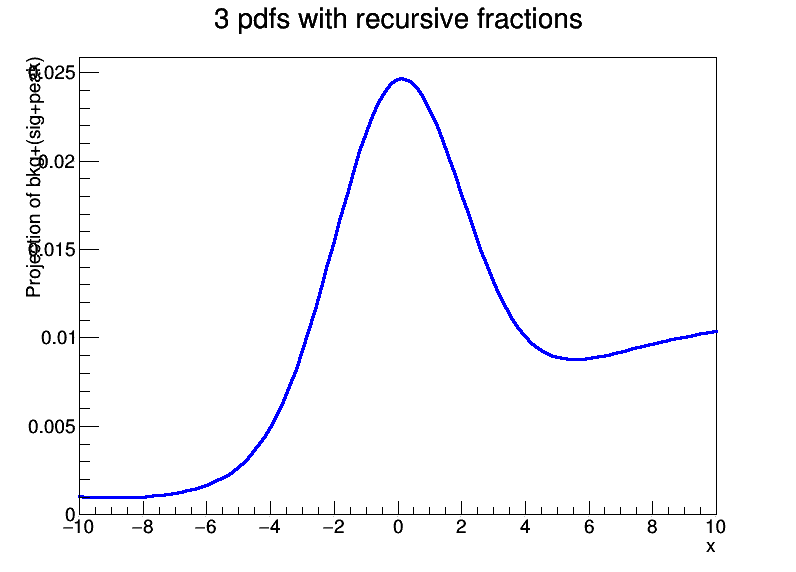

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpZuUbeP.png has been created


In [7]:
model = ROOT.RooAddPdf("model","bkg+(sig+peak)",ROOT.RooArgList(bkg,bkg_peak,sig),ROOT.RooArgList(fbkg,fpeak),ROOT.kTRUE)

xframe = x.frame(ROOT.RooFit.Title("3 pdfs with recursive fractions"))
model.plotOn(xframe)
xframe.Draw()
c1

## Plotting Composite Models

This modular stucture of a composite p.d.f allows plotting of the different components in an intuative way.

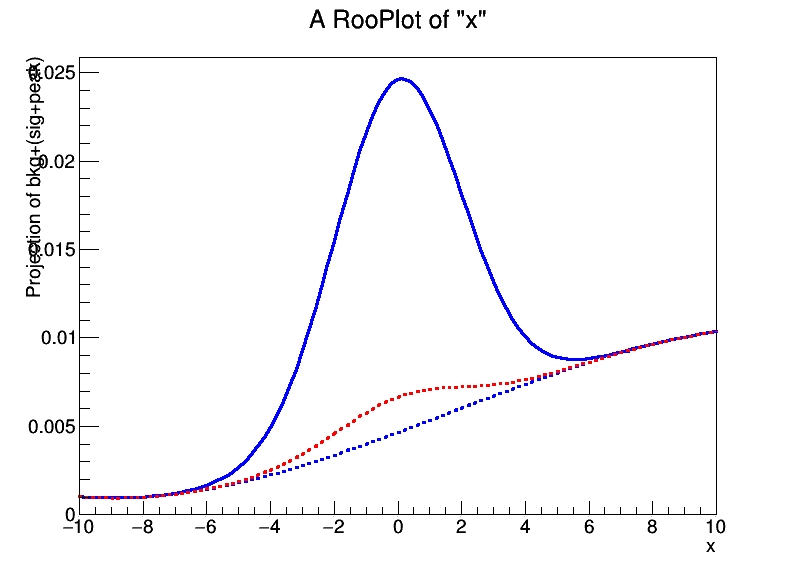

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg,bkg_peak)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpJ1XxZK.png has been created


In [8]:
xframe = x.frame()
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(bkg)
bkg_peak_component = ROOT.RooArgSet(bkg,bkg_peak)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2))
model.plotOn(xframe,ROOT.RooFit.Components(bkg_peak_component),ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1

In this example the usual pyROOT work around of explictitly redefining variables required to work arround the c++ overloading seems to break down because of differences in the C++ and python scoping rules. i.e. it accepts the component when passed to the plotOn function but then looses it before plotting. The work around it to define the component explicitly.

The methods for fitting and generating data from these models is identical to that in the previous notebook.

In [9]:
data = model.generate(ROOT.RooArgSet(x),10000)
model.fitTo(data,ROOT.RooFit.PrintLevel(-1))

[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bkg,bkg_peak,sig)
 MINUIT WARNING IN MIGrad    
 ============== VARIABLE1 IS AT ITS UPPER ALLOWED LIMIT.


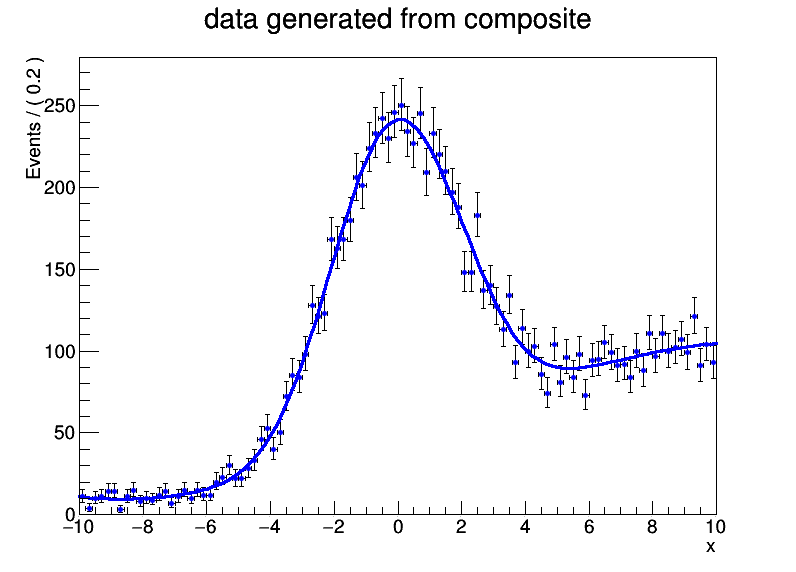

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmphb1KVG.png has been created


In [10]:
xframe = x.frame(ROOT.RooFit.Title("data generated from composite"))
data.plotOn(xframe)
model.plotOn(xframe)
xframe.Draw()
c1

## Building Extended Composite Models

plain component (non-extended) pdfs can be extended by specifying an equal number of components and coefficients.

In [11]:
nsig = ROOT.RooRealVar("nsig","signal fraction",500,0.,10000.)
nbkg = ROOT.RooRealVar("nbkg","background fraction",500,0.,10000.)

model = ROOT.RooAddPdf("model","extended model",ROOT.RooArgList(sig,bkg),ROOT.RooArgList(nsig,nbkg))

It's also possible to make a RooAddPdf from extended RooAddPdf's by simply not providing coefficients

In [12]:
esig = ROOT.RooExtendPdf("esig","esig",sig,nsig)
ebkg = ROOT.RooExtendPdf("ebkg","ebkg",bkg,nbkg)

model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(esig,ebkg))

The two definitions of 'model' above are functionally identical however the RooExtendPdf also offers extra functionality to interpret event counts in a different range.

In [13]:
x = ROOT.RooRealVar("x","x",0,10)

# narrow signal
mean = ROOT.RooRealVar("mean","mean",5,0,10)
sigma = ROOT.RooRealVar("sigma","sigma",0.3,0.,10.)
sig = ROOT.RooGaussian("sig","signal p.d.f.",x,mean,sigma)

# wide background
coef0 = ROOT.RooRealVar("c0","coefficient #0",1.0,-1.,1)
coef1 = ROOT.RooRealVar("c1","coefficient #1",0.1,-1.,1)
coef2 = ROOT.RooRealVar("c2","coefficient #2",-0.1,-1.,1)
bkg = ROOT.RooChebychev("bkg","background p.d.f.",x,ROOT.RooArgList(coef0,coef1,coef2))

#peaked background
mean_bkg = ROOT.RooRealVar("mean_bkg","mean",4.5,0,10)
sigma_bkg = ROOT.RooRealVar("sigma_bkg","sigma",2,0.,10.)
bkg_peak = ROOT.RooGaussian("bkg_peak","peaking bkg p.d.f",x,mean_bkg,sigma_bkg)

#expected yeilds
nsig = ROOT.RooRealVar("nsig","n signal",50,0,10000)
nbkg = ROOT.RooRealVar("nbkg","n background (non-peak)",500,0,10000)
nbkg_peak = ROOT.RooRealVar("nbkg_peak","n background (peaked)",450,0,10000)

esig = ROOT.RooExtendPdf("esig","esig",sig,nsig)
ebkg = ROOT.RooExtendPdf("ebkg","ebkg",bkg,nbkg)
ebkg_peak = ROOT.RooExtendPdf("ebkg_peak","ebkg_peak",bkg_peak,nbkg_peak)

model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(esig,ebkg,ebkg_peak))

data = model.generate(ROOT.RooArgSet(x),1000)

Here I have generated 1000 events according to the model that expects 50 signal events, 450 peaked background events, and 500 broad spectrum background events. The composite p.d.f is built from extended pdfs.

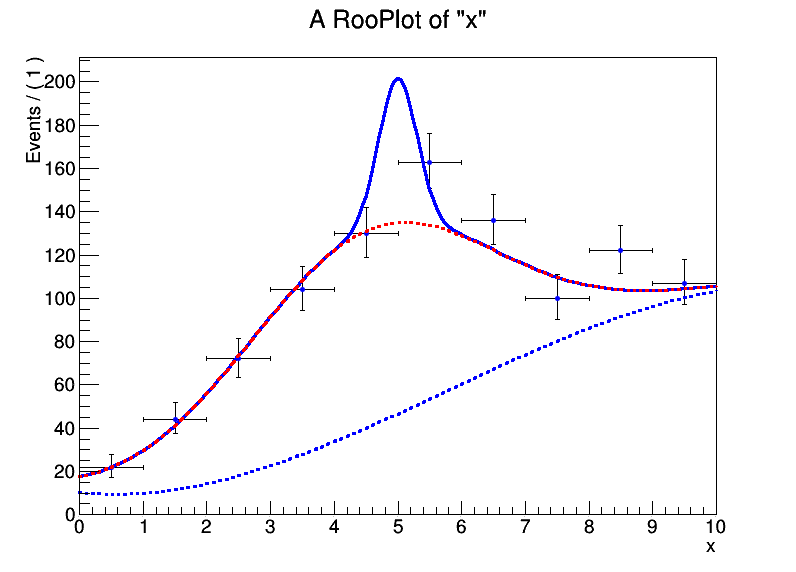

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (ebkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg,bkg_peak)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (ebkg,ebkg_peak)


Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpWBXZlB.png has been created


In [14]:
xframe = x.frame()
data.plotOn(xframe,ROOT.RooFit.Binning(10))
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(bkg)
bkg_peak_component = ROOT.RooArgSet(bkg,bkg_peak)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2))
model.plotOn(xframe,ROOT.RooFit.Components(bkg_peak_component),ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1

Now supposed we want to extrapolate the signal yeild in the range 4-6. 

In [15]:
x.setRange("window",4,6)
l=ROOT.RooArgSet(x)
fracSigRange = sig.createIntegral(l,l,"window")
nsigWindow = nsig.getVal()*fracSigRange.getVal()
nsigWindow

49.957093966680326

[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'window' created with bounds [4,6]


I think that's pretty close to the expected 50 events ;) However the errors on both the signal yield and the fraction of the shape integral would have to be propageded manually. RooExtendPdf however allows us the possibility to apply the transformation inside of the calculation such that the likelihood and therefore the fit result is expressed in terms of nsigWindow and all errors automatically propagated.

In [16]:
nsigw = ROOT.RooRealVar("nsigw","n signal in window",50,0,10000)
esig = ROOT.RooExtendPdf("esig","esig",sig,nsigw,"window")

Now if we minimise the extended maximum likelihood, nsigw equals the best estimate for the number of events in the signal window
$$N_{sig}^{expected}\frac{N_{sig}^{window}}{\int_4^6S(x)dx}$$

## Using Extended Composite Models

### Generating Events

In [17]:
x = ROOT.RooRealVar("x","x",0,10)

# narrow signal
mean = ROOT.RooRealVar("mean","mean",5,0,10)
sigma = ROOT.RooRealVar("sigma","sigma",0.3,0.,10.)
sig = ROOT.RooGaussian("sig","signal p.d.f.",x,mean,sigma)

# wide background
coef0 = ROOT.RooRealVar("c0","coefficient #0",1.0,-1.,1)
coef1 = ROOT.RooRealVar("c1","coefficient #1",0.1,-1.,1)
coef2 = ROOT.RooRealVar("c2","coefficient #2",-0.1,-1.,1)
bkg = ROOT.RooChebychev("bkg","background p.d.f.",x,ROOT.RooArgList(coef0,coef1,coef2))

#peaked background
mean_bkg = ROOT.RooRealVar("mean_bkg","mean",4.5,0,10)
sigma_bkg = ROOT.RooRealVar("sigma_bkg","sigma",2,0.,10.)
bkg_peak = ROOT.RooGaussian("bkg_peak","peaking bkg p.d.f",x,mean_bkg,sigma_bkg)

#expected yeilds
nsig = ROOT.RooRealVar("nsig","n signal",50,0,10000)
nbkg = ROOT.RooRealVar("nbkg","n background (non-peak)",500,0,10000)
nbkg_peak = ROOT.RooRealVar("nbkg_peak","n background (peaked)",450,0,10000)

esig = ROOT.RooExtendPdf("esig","esig",sig,nsig)
ebkg = ROOT.RooExtendPdf("ebkg","ebkg",bkg,nbkg)
ebkg_peak = ROOT.RooExtendPdf("ebkg_peak","ebkg_peak",bkg_peak,nbkg_peak)

model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(esig,ebkg,ebkg_peak))

data = model.generate(ROOT.RooArgSet(x),1000)

In the above example I explicitly generated 1000 events since this is what was predicted by the model. This can simply be omitted.

In [18]:
data = model.generate(ROOT.RooArgSet(x))

Keep in mind that in the lines above x was in windowed mode, so either skip that re-definition or redefine x here.

By omiting the number of events, the number predicted by the p.d.f. is given. You can optionally introduce a Poisson fluctuation in the number of generated events by using the Extended() argument in RooFit. this is useful in the case of generating samples for a study looking at pull distributions. In this case a Poisson fluctuation on the total number of events generated should be present. 

In [19]:
data = model.generate(ROOT.RooArgSet(x),ROOT.RooFit.Extended(ROOT.kTRUE))

### Fitting

In principle, fitting is also done as before however composite extended p.d.f's can only be sucessfully fit if the extended likelihood term is included in the minimisation, because of the extra degree of freedom that is constrained by this term. If a p.d.f. is capable of calculating this extra term (e.g. any extended RooAddPdf object) the extended term is automatically included in the likelihood calculation. You can manually override this using the Extended() argument from RooFit

In [20]:
model.fitTo(data,ROOT.RooFit.Extended(ROOT.kTRUE),ROOT.RooFit.PrintLevel(-1))

[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (esig,ebkg,ebkg_peak)
 MINUIT WARNING IN MIGrad    
 ============== VARIABLE1 IS AT ITS UPPER ALLOWED LIMIT.


### Plotting

Default plotting for extended likelihood models is the same as for regular pdfs. The event count used for normalisation is that of the last dataset added to the plot frame (not the first as in TH1.Draw() ) There is the option to override this behaviour and use the expected event count of the pdf for the normalisation

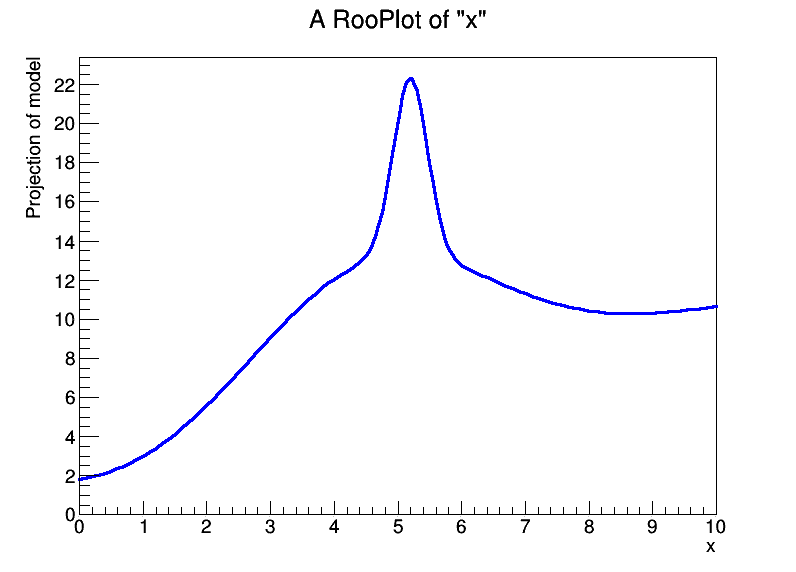

Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmp4Xbxh0.png has been created


In [21]:
xframe = x.frame()
model.plotOn(xframe,ROOT.RooFit.Normalization(1.,ROOT.RooAbsReal.ScaleType(3)))
xframe.Draw()
c1

### Note on the Interpretation of fraction coefficients and ranges

A closer look at the expression for composite p.d.f's
$$M(x)=\sum^{N-1}_{i=1}f_1F_1(x)+\left(1-\sum^{N-1}_{i=1}f_1\right)F_N(x)$$
shows that the fraction coefficients multiply normalized p.d.f's shapes, which has important consequences for the interpretation of these fraction coefficients: if the range of an observable is changed, the *shape* of the p.d.f. will change.

In [22]:
x = ROOT.RooRealVar("x","x",-10,10)

mean = ROOT.RooRealVar("mean","mean",0,-10,10)
sigma = ROOT.RooRealVar("sigma","sigma",2,0.,10)
sig = ROOT.RooGaussian("sig","signal p.d.f.",x,mean,sigma)

coef0 = ROOT.RooRealVar("c0","coefficient #0",1.0,-10.,10)
coef1 = ROOT.RooRealVar("c1","coefficient #1",0.1,-10.,10)
coef2 = ROOT.RooRealVar("c2","coefficient #2",-0.1,-10.,10)
bkg = ROOT.RooChebychev("bkg","background p.d.f.",x,ROOT.RooArgList(coef0,coef1,coef2))

fsig = ROOT.RooRealVar("fsig","signal fraction",0.5,0.,1.)

# model(x) = fsig*sig(x) + (1-fsig)*bkg(x)
model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(sig,bkg),ROOT.RooArgList(fsig))

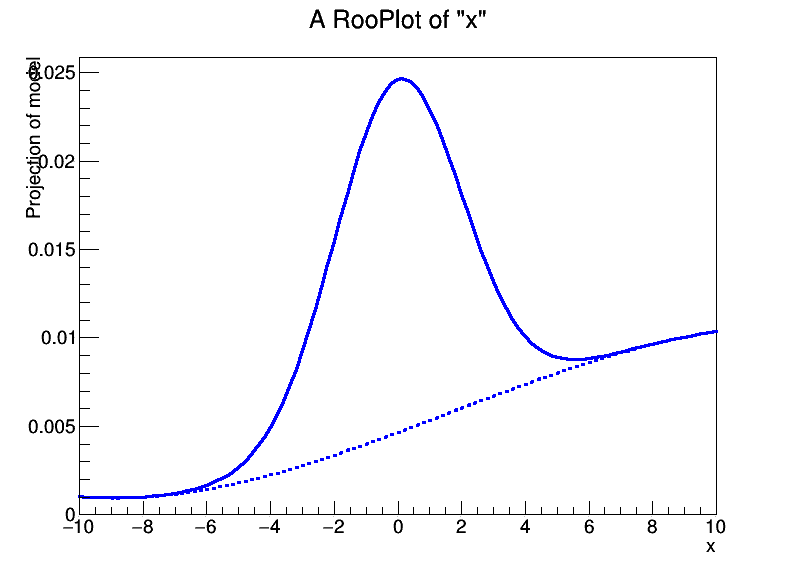

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpwEdKsC.png has been created


In [23]:
xframe = x.frame()
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(bkg)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2))
xframe.Draw()
c1

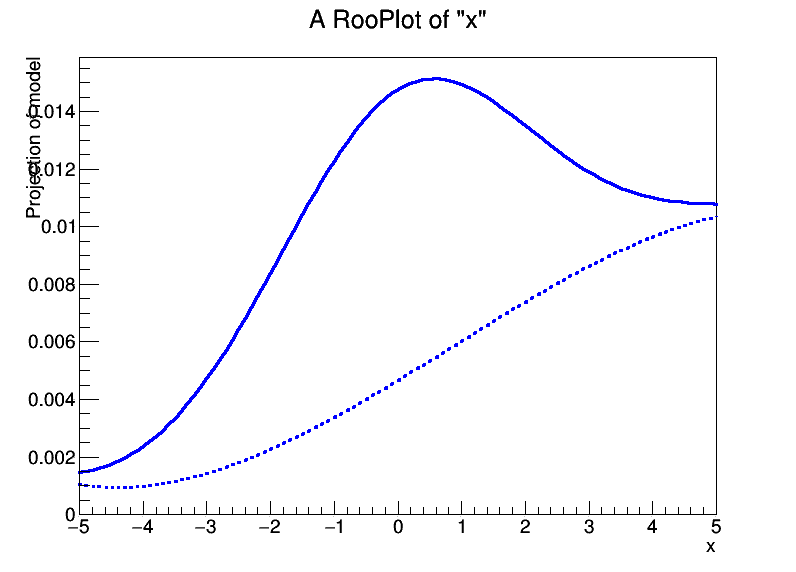

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file /var/folders/sk/t5qncxyd1gjg61whtngc502r0000gn/T/tmpM2qe0v.png has been created


In [24]:
x.setRange(-5,5)
xframe = x.frame()
model.plotOn(xframe)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2))
xframe.Draw()
c1

## Navigation Tools for Dealing with Composite Objects

One of the added complications of using composite model versus using basic p.d.f.s is that you no longer know what the variables of your model are. RooFit provides several tools for dealing with composite objects when you only have direct access to the top-level node of the expression tree, i.e. the model object in the preceding examples.

### What are the Variables of My Model

Given any composite RooFit value object, the getVariables() method returns you a RooArgSet with all parameters of your model

In [25]:
model.getVariables().Print("v")

  1) 0x117e44190 RooRealVar::    c0 = 1  L(-10 - 10)  "coefficient #0"
  2) 0x117e44540 RooRealVar::    c1 = 0.1  L(-10 - 10)  "coefficient #1"
  3) 0x117e448f0 RooRealVar::    c2 = -0.1  L(-10 - 10)  "coefficient #2"
  4) 0x117e44ca0 RooRealVar::  fsig = 0.5  L(0 - 1)  "signal fraction"
  5) 0x117e43a30 RooRealVar::  mean = 0  L(-10 - 10)  "mean"
  6) 0x117e43de0 RooRealVar:: sigma = 2  L(0 - 10)  "sigma"
  7) 0x117e67300 RooRealVar::     x = 0  L(-5 - 5)  "x"


If you know the name of a variable, you can retrieve a pointer to the object through the find() method of RooArgSet:

In [26]:
c0 = model.getVariables().find("c0") 
c0.setVal(5.3) 

Although sets can contain any RooFit value type (any class derived from RooAbsArg) one deals in practice usually with sets of all RooRealVars. Therefore class RooArgSet is equipped with some special member functions to simplify operations on such sets. The above example can be shortened to

In [27]:
model.getVariables().setRealValue("c0",-15.3)

False

Interestingly the value this is set to must be within the range of the parameter or else that limit is returned

In [28]:
c0.getVal()

-10.0

### What is the structure of my composite model?
In addition to manipulation of the parameters one may also wonder what the structure of a given model is. For an easy visual inspection of the tree structure use the tree printing mode

In [29]:
model.Print("t")

0x1170b4200 RooAddPdf::model = 0.95 [Auto,Dirty] 
  0x11700ea00/V- RooGaussian::sig = 1 [Auto,Dirty] 
    0x117e67300/V- RooRealVar::x = 0
    0x117e43a30/V- RooRealVar::mean = 0
    0x117e43de0/V- RooRealVar::sigma = 2
  0x117e44ca0/V- RooRealVar::fsig = 0.5
  0x1170dbc00/V- RooChebychev::bkg = 0.9 [Auto,Dirty] 
    0x117e67300/V- RooRealVar::x = 0
    0x117e44190/V- RooRealVar::c0 = -10
    0x117e44540/V- RooRealVar::c1 = 0.1
    0x117e448f0/V- RooRealVar::c2 = -0.1


For each lists object you will see the pointer to the object, following by the class name and object name and finally the object title in parentheses.
A composite object tree is traversed top-down using a depth-first algorithm. With each node traversal the indentation of the printout is increased. This traversal method implies that the same object mayappear more than once in this printout if it is referenced in more than one place. See e.g. the multiple reference of observable x in the example above.

The set of components of a p.d.f can also be accessed through the utility method getComponents(), which will return all the ‘branch’ nodes of its expression tree and is the complement of getVariables(), which returns the ‘leaf’ nodes. The example below illustrates the use of getComponents() to only print out the variables of model component “sig”:

In [30]:
components = model.getComponents()
sig = components.find("sig")
sigVars = sig.getVariables()

sigVars.Print()

RooArgSet::parameters = (mean,sigma,x)


### Graphic representation of the structure of a composite model
A graphic representation of a models structure can be constructed with aid of the GraphViz suite of graph visualization tools7. You can write a file with a GraphViz representation of a tree structure of any composite object using the method RooAbsArg::graphVizTree():

In [31]:
model.graphVizTree("model.dot")

Then GraphViz tools needs to be instaled. on unix the command 
> dot -Tgif -o model.gif model.dot     # Directed graph

This produces the image: <img src="model.gif">

Whereas a spring balanced model is produced by the command
> fdp -Tgif -o model_fdp.gif model.dot     # Directed graph

As seen here: <img src="model_fdp.gif">